In [ ]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [ ]:
from enum import Enum

class OptionType(Enum):
    call, put = range(0,2)

European Binomial Tree

In [ ]:
from dataclasses import dataclass

@dataclass
class Option:

    s_ini: int
    strike_price: int
    maturity: int
    risk_free_rate: float
    sigma: float
    steps: int
    option_type: OptionType

In [ ]:
class BinomialTree:
    def __init__(self, option: Option):
        self.option = option
        self.dt = option.maturity / option.steps
        self.u = np.exp(option.sigma * np.sqrt(self.dt))
        self.d = np.exp(-option.sigma * np.sqrt(self.dt))
        self.p = (np.exp(option.risk_free_rate * self.dt) - self.d) / (self.u - self.d)
        self.price_matrix = np.zeros([option.steps + 1, option.steps + 1])
        self.underlying_matrix = np.zeros([option.steps + 1, option.steps + 1])
        self.delta_matrix = np.zeros([option.steps, option.steps])

    def price(self):

      N = self.option.steps
      for i in range(0,N+1):

        # price on tree edges
        self.underlying_matrix[N,i] = self.option.s_ini* (self.u ** (i)) * (self.d ** (N-i))

        # call
        if self.option.option_type == OptionType.call:
          self.price_matrix[N,i] = max(self.underlying_matrix[N,i] - self.option.strike_price, 0)
        # put
        else:
          self.price_matrix[N,i] = max(self.option.strike_price-self.underlying_matrix[N,i],0)

      for j in range(N-1,-1,-1):
        for i in range(0,j+1):
          self.price_matrix[j,i] = np.exp(-self.option.risk_free_rate*self.dt)*(self.p*self.price_matrix[j+1,i+1]+(1-self.p)*self.price_matrix[j+1,i])
          self.underlying_matrix[j,i] = self.option.s_ini*(self.u**(i))*(self.d**(j-i))
          self.delta_matrix[j,i] = (self.price_matrix[j+1,i+1]-self.price_matrix[j+1,i])/(self.underlying_matrix[j+1,i+1]-self.underlying_matrix[j+1,i])


      return {
              "price" : self.price_matrix[0,0],
              "underlying" : self.underlying_matrix,
              "delta" : self.delta_matrix
              }


In [ ]:
call_option = Option(100, 110, 3/12,0.05, 0.2, 200, OptionType.call)
binomial_tree = BinomialTree(call_option)
call_price = binomial_tree.price()["price"]
print("call price: {:.2f}".format(call_price))

call price: 1.19


In [ ]:
price_array = []

for N in [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]:
    call_option = Option(100, 110, 3/12,0.05, 0.2, N, OptionType.call)
    res = BinomialTree(call_option).price()
    call_price = res["price"]
    price_array.append(call_price)


In [ ]:
time_array = []
for N in [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]:
    start = timer()
    call_option = Option(100, 110, 3/12,0.05, 0.2, N, OptionType.call)
    res = BinomialTree(call_option).price()
    end = timer()
    time_array.append(end-start)

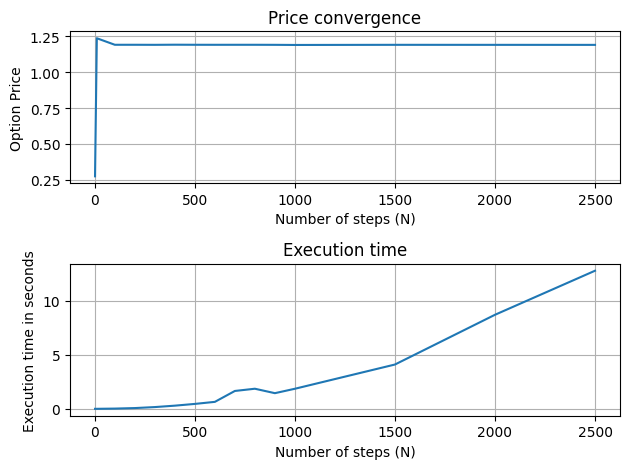

In [ ]:

N = [1, 10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2500]
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(N, np.array(price_array))
ax1.set_title("Price convergence")
ax2.plot(N ,np.array(time_array))
ax2.set_title("Execution time")
ax1.grid(True)
ax2.grid(True)
ax1.set_xlabel("Number of steps (N)")
ax1.set_ylabel("Option Price")
ax2.set_xlabel("Number of steps (N)")
ax2.set_ylabel("Execution time in seconds")
fig.tight_layout()

Comparing call and put deltas

In [ ]:
call_option = Option(100, 110, 3/12,0.05, 0.2, 200, OptionType.call)
put_option = Option(100, 110, 3/12,0.05, 0.2, 200, OptionType.put)

res_call = BinomialTree(call_option).price()
res_put = BinomialTree(put_option).price()

In [ ]:
call_delta = res_call["delta"][0][0]
print("call delta: {:.2f}".format(call_delta))

call delta: 0.22


In [ ]:
put_delta = res_put["delta"][0][0]
print("put delta: {:.2f}".format(put_delta))

put delta: -0.78


Computing vega

In [ ]:
sigma_25 = 0.25
call_option_vg_25 = Option(100, 110, 3/12,0.05,sigma_25, 200, OptionType.call)
put_option_vg_25 = Option(100, 110, 3/12,0.05, sigma_25, 200, OptionType.put)

res_call = BinomialTree(call_option).price()["price"]
res_put = BinomialTree(put_option).price()["price"]

In [ ]:
#vega

call_vega = (BinomialTree(call_option_vg_25).price()["price"]-res_call)/0.05
put_vega = (BinomialTree(put_option_vg_25).price()["price"]-res_put)/0.05

print("call vega: {:.2f}".format(call_vega))
print("put vega: {:.2f}".format(put_vega))


call vega: 15.86
put vega: 15.84


Trinomial Tree